<a href="https://colab.research.google.com/github/crystalloide/Notebooks-SQL-serie-1/blob/main/ex13_Utilisation_de_SQLite_comme_base_de_donn%C3%A9es_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ex13-Utilisation de SQLite comme base de données de séries chronologiques (Time Series)

SQLite prend en charge cinq fonctions ***date*** et ***time*** comme suit:
1. date(timestring, modifier, modifier, ...)
2. time(timestring, modifier, modifier, ...)
3. datetime(timestring, modifier, modifier, ...)
4. julianday(timestring, modifier, modifier, ...)
5. strftime(format, timestring, modifier, modifier, ...)

Ces cinq fonctions de date et d'heure prennent une chaîne d'heure comme argument. 

La chaîne de temps est suivie de zéro ou plusieurs modificateurs. 

La fonction strftime() prend également une chaîne de format comme premier argument. 

Avec ces fonctions de date et d'heure, nous pouvons enregistrer des données de séries chronologiques dans une base de données SQLite afin d'utiliser SQLite comme base de données de séries chronologiques.

Dans ce notebook, nous allons créer une table pour enregistrer les données de température artificielles à différentes dates et heures. 

Vous pouvez supposer qu'ils sont collectés à partir de certains types de capteurs de température.

Ce TP permettra de :

- Mettre en pratique des fonctions sur les heures et les dates
- Créer une table de température et son index
- Insérez des données dans la table des températures
- Requêter les informations


In [1]:
%load_ext sql

In [2]:
from random import uniform, choice
import time
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline

In [3]:
from google.colab import drive
# drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)


Mounted at /content/gdrive


### 1. Connection à la database demo.db3

In [4]:
%sql sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3

'Connected: @/content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3'

### 2. Jouons avec les fonctions de date et d'heure

Vous pouvez trouver plus d'exemples sur  [lang_datefunc](https://www.sqlite.org/lang_datefunc.html) ou [sqlite_date_time](https://www.tutorialspoint.com/sqlite/sqlite_date_time.htm)

- Récupérons la date du jour : 


In [5]:
%sql SELECT date('now');

 * sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3
Done.


date('now')
2021-01-08


- Compute the last day of the current month.

In [6]:
%sql SELECT date('now','start of month','+1 month','-1 day');

 * sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3
Done.


"date('now','start of month','+1 month','-1 day')"
2021-01-31


- Compute the date of the first Tuesday in October for the current year.

In [7]:
%sql SELECT date('now','start of year','+9 months','weekday 2');

 * sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3
Done.


"date('now','start of year','+9 months','weekday 2')"
2021-10-05


### 3. Creation de la table time series des temperatures 

#### 3.1 Creation de la table

avec seulement deux colonnes : Timestamp et Temperature

In [8]:
%%sql sqlite://
DROP TABLE IF EXISTS Temperature;
CREATE TABLE Temperature (Timestamp DATETIME NOT NULL, Temperature NUMERIC NOT NULL)

Done.
Done.


[]

#### 3.2 Create an index

For efficient querying, we'll want to index the timestamp column.

In [9]:
%%sql sqlite://
CREATE UNIQUE INDEX idx_timestamp ON Temperature (Timestamp);

Done.


[]

#### 3.3 Insert data

Make 500 rows of data and temperature ranges between 18 to 26.

In [10]:
def dt(days):
    return timedelta(days=days)

N_rows = 500
now = datetime.now()

for i in range(N_rows):
    timestamp = now - dt(days=(N_rows - i))
    temperature = uniform(18, 26)
    %sql INSERT INTO Temperature VALUES (:timestamp, :temperature);  

 * sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3
1 rows affected.
 * sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3
1 rows affected.
 * sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3
1 rows affected.
 * sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3
1 rows affected.
 * sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3
1 rows affected.
 * sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3
1 rows affected.
 * sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3
1 rows affected.
 * sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3
1 rows affected.
 * sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3
1 rows affected.
 * sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3
1 rows affected.
 * sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3
1 rows affected.
 * sqlite:////content

### 4. Play with time series table

#### 4.1 Simple Query

In [11]:
%sql SELECT datetime(Timestamp) as Date, Temperature FROM Temperature LIMIT 5

 * sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3
Done.


Date,Temperature
2019-08-27 11:57:48,22.253471081574077
2019-08-28 11:57:48,25.60456435316248
2019-08-29 11:57:48,24.878999036494854
2019-08-30 11:57:48,20.938416081362256
2019-08-31 11:57:48,22.03585426176057


#### 4.2 Filter with a datetime

In [12]:
%%sql sqlite://
SELECT Timestamp as Date, Temperature
FROM Temperature
WHERE Date <= '2017-12-31 14:21:45'

Done.


Date,Temperature


#### 4.3 Requêtons sur une année spécifique

Utilisons la fonction CAST pour transformer une chaîne en un entier, puisque la fonction **strftime** retourne une chaîne.

In [13]:
%%sql sqlite://
SELECT Timestamp as Date, Temperature 
FROM Temperature
WHERE CAST(strftime('%Y', Date) as Int) = 2017

Done.


Date,Temperature


#### 4.5 Aggregation annuelle

In [14]:
%%sql sqlite://
SELECT strftime('%Y', Timestamp) as Year, 
       AVG(Temperature) AS MEAN_TMP,
       MAX(Temperature) AS MAX_TMP,
       MIN(Temperature) AS MIN_TMP
FROM Temperature
GROUP BY strftime('%Y', Timestamp) 

Done.


Year,MEAN_TMP,MAX_TMP,MIN_TMP
2019,22.15086930156451,25.905566038714298,18.024254462485175
2020,22.14909172758773,25.961537307454048,18.035031705658458
2021,21.06332461859563,24.340627941397464,18.206644867637642


### 5. Visualisation

Convertissons les résultats de la requête en DataFrame pandas

In [15]:
ts = %sql SELECT datetime(Timestamp) as date, Temperature FROM Temperature
df = ts.DataFrame()
df.set_index("date", inplace = True) 
df.index = pd.to_datetime(df.index)
df.index

 * sqlite:////content/gdrive/MyDrive/Partage/Notebooks_Serie_1/demo.db3
Done.


DatetimeIndex(['2019-08-27 11:57:48', '2019-08-28 11:57:48',
               '2019-08-29 11:57:48', '2019-08-30 11:57:48',
               '2019-08-31 11:57:48', '2019-09-01 11:57:48',
               '2019-09-02 11:57:48', '2019-09-03 11:57:48',
               '2019-09-04 11:57:48', '2019-09-05 11:57:48',
               ...
               '2020-12-29 11:57:48', '2020-12-30 11:57:48',
               '2020-12-31 11:57:48', '2021-01-01 11:57:48',
               '2021-01-02 11:57:48', '2021-01-03 11:57:48',
               '2021-01-04 11:57:48', '2021-01-05 11:57:48',
               '2021-01-06 11:57:48', '2021-01-07 11:57:48'],
              dtype='datetime64[ns]', name='date', length=500, freq=None)

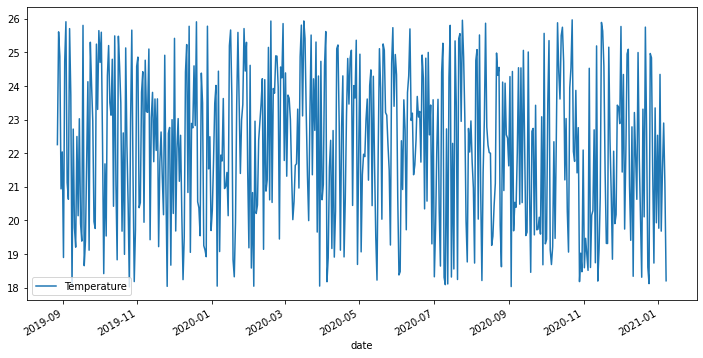

In [16]:
df.plot(figsize=(12, 6))

### Conclusion et références 

Les bases de données de séries chronologiques (TSDB) sont de plus en plus populaires ces jours-ci. 

Il existe de nombreuses Bases de données de ce type (https://en.wikipedia.org/wiki/Time_series_database) telles que :
> InfluxDB, Graphite, Druid, Kairos et Prometheus.

Avec les fonctions de date et d'heure de SQLite, nous pouvons enregistrer des données de séries chronologiques dans une base de données SQLite afin d'utiliser SQLite comme base de données de séries chronologiques (time series database). 

https://www.sqlite.org/lang_datefunc.html

https://www.tutorialspoint.com/sqlite/sqlite_date_time.htm